In [138]:
%run bert.ipynb

attention pattern raw MATCH!!!!!!!!
 SHAPE (2, 12, 3, 3) MEAN: 0.01006 STD: 0.1024 VALS [0.06386 0.1717 0.09479 -0.1053 -0.129 0.1975 -0.04917 0.1681 0.1743 -0.1699...]
attention MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.005909 STD: 0.117 VALS [0.1238 -0.3232 0.0477 -0.002902 -0.08322 -0.07245 -0.1454 0.2138 -0.06376 0.08799...]
bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.001554 STD: 0.1736 VALS [-0.08316 -0.09165 -0.03188 -0.03013 0.1001 0.09549 -0.1046 0.07742 0.0424 0.05553...]
bert mlp MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.0001934 STD: 0.1044 VALS [-0.1153 0.1189 -0.0813 0.1021 0.0296 0.06182 0.0341 0.1446 0.2622 -0.08507...]
layer norm MATCH!!!!!!!!
 SHAPE (20, 10) MEAN: -1.431e-08 STD: 1.003 VALS [0.6906 -0.84 1.881 1.711 -0.5116 -0.9577 -0.1387 -0.6943 -0.6741 -0.4662...]
bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -5.381e-09 STD: 1 VALS [0.007132 -0.04372 0.6502 -0.5972 -1.097 0.7267 0.1275 -0.6035 -0.2226 0.2145...]
{'input_ids': [[101, 8667, 117, 146, 1821, 170, 5650, 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [139]:
import transformers
from tqdm.notebook import tqdm
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")

In [140]:
def make_bert():
    my_bert = Bert(
        vocab_size=28996, hidden_size=768, max_position_embeddings=512, 
        type_vocab_size=2, dropout=0.1, intermediate_size=3072, 
        num_heads=12, num_layers=12, num_classes=2
    )
    pretrained_state_dict = pretrained_bert.state_dict()

    #pretrained_keys = pretrained_state_dict.keys()
    #my_keys = my_bert.state_dict().keys()
    #print(set(my_keys) - set(pretrained_keys))

    # we could load these but actually we want to be fine-tuning this stuff in w2d2
    # so let's not take these 
    del pretrained_state_dict["classification_head.weight"]
    del pretrained_state_dict["classification_head.bias"]

    my_bert.load_state_dict(pretrained_state_dict, strict=False)
    
    return my_bert

In [141]:
def ascii_art_probs(sentence):
    bert = make_bert()
    token_ids = torch.Tensor(tokenizer.encode(sentence)).long().unsqueeze(0)
    mask_idxs = set()
    for idx, token_id in enumerate(token_ids[0]):
        if token_id == 103: # 103 == [MASK]
            mask_idxs.add(idx)
    unnormalized_output, _classifications = bert(token_ids)
    output = torch.log_softmax(unnormalized_output, dim=-1)
    top_k = torch.topk(output, 5, dim=-1)
    results = []
    for seq_i, seq_top_k in enumerate(top_k.indices[0]):
        if seq_i in mask_idxs:
            results.append(list(zip(tokenizer.convert_ids_to_tokens(seq_top_k), [round(x.item(), 2) for x in top_k.values[0][seq_i].exp()])))
    for l in results:
        print(l)

ascii_art_probs("The fish loves to eat [MASK] and [MASK] and [MASK] and [MASK] and [MASK] and [MASK] and [MASK].")


[('fish', 0.2), ('eggs', 0.08), ('meat', 0.07), (',', 0.07), ('apples', 0.03)]
[('fish', 0.14), ('eggs', 0.07), ('meat', 0.06), ('potatoes', 0.04), ('vegetables', 0.03)]
[('fish', 0.1), ('meat', 0.05), ('eggs', 0.03), ('salt', 0.03), ('bread', 0.02)]
[('fish', 0.08), ('eggs', 0.03), ('meat', 0.03), ('food', 0.02), ('salt', 0.02)]
[('fish', 0.06), ('eggs', 0.03), ('salt', 0.02), ('meat', 0.02), ('vegetables', 0.02)]
[('fish', 0.06), ('salt', 0.02), ('meat', 0.02), ('food', 0.02), ('water', 0.01)]
[('fish', 0.07), ('more', 0.03), ('honey', 0.02), ('meat', 0.02), ('salt', 0.01)]


In [142]:
# class ClassificationBERT():
#     def __init__(self, num_classes):
#         VOCAB_SIZE = 28996
#         DROPOUT=0.1
#         self.bert = Bert(
#             vocab_size=VOCAB_SIZE, hidden_size=768, max_position_embeddings=512, 
#             type_vocab_size=2, dropout=DROPOUT, intermediate_size=3072, 
#             num_heads=12, num_layers=12
#         )
#         self.dropout = torch.nn.Dropout(DROPOUT)
#         # TODO attach this to the last block of BERT as a hidden_size x num_classes linear layer,
#         # not on top of the vocab_size output of BERT
#         self.classification_head = torch.nn.Linear(VOCAB_SIZE, num_classes)

#         pretrained_state_dict = pretrained_bert.state_dict()
#         del pretrained_state_dict["classification_head.weight"]
#         del pretrained_state_dict["classification_head.bias"]
#         self.bert.load_state_dict(pretrained_state_dict)

#     def forward(self, X):
#         return self.classification_head(self.dropout(self.bert(X)))

In [143]:
import torchtext
import random
data_train, data_test = torchtext.datasets.IMDB(root='.data', split=('train', 'test'))
data_train_list = list(data_train)
random.shuffle(data_train_list)

In [144]:

def make_batches(data_train_list, batch_size, max_seq_len):
    batches = []
    for batch_start in range(0, len(data_train_list), batch_size):
        batch_end = min(batch_start + batch_size, len(data_train_list))
        ratings, sentences = [list(tup) for tup in list(zip(*data_train_list[batch_start:batch_end]))]
        tokens = tokenizer(sentences, padding='longest', max_length=max_seq_len, truncation=True)
        ratings01 = torch.tensor([ rating == 'pos' for rating in ratings ], dtype=torch.long)
        tokens_tensor = torch.tensor(tokens.input_ids, dtype=torch.long)
        batches.append((tokens_tensor, ratings01))
    return batches

In [145]:
for review, sentiment in make_batches(data_train_list[:5], 1, 100):
    print(tokenizer.decode(review[0]), sentiment)

[CLS] This movie is about a young scientist who creates a serum that re - animates the dead. He first uses it on his brother when he is shot dead in a drive by. His brother then infects the other gang members. In some scenes the zombies are seen walking very slowly and in other scenes they run pretty fast which makes little sense. The acting is mediocre but the story doesn't help the film. The makeup consists of blood on the face of the zombies [SEP] tensor([0])
[CLS] Forbidden Planet represents the kind of science fiction that is precious in cinema, especially from the 1950s. There was The Day the Earth Stood Still and War of the Worlds, but lest not forget this gem which took some of its story from Shakespeare's The Tempest to tell a tale of astronauts on a planet that has a doctor on it who has made a remarkable breakthrough. It's the kind of breakthrough that is not so much incredible to look at ( though for [SEP] tensor([1])
[CLS] Most of the French films I've seen - and enjoyed -

In [146]:

data = make_batches(data_train_list, 16, 512)
bert = make_bert().cuda()
lossfn = nn.CrossEntropyLoss()

In [147]:

lr = 1e-5
optimizer = torch.optim.Adam(bert.parameters(), lr)

In [148]:
for param in bert.parameters():
    param.retain_grad()

  0%|          | 0/1563 [00:00<?, ?it/s]

tensor([ 5.9873e-06, -6.6157e-04, -7.8579e-04, -1.4045e-03, -4.2896e-04,
         3.8002e-04,  6.0143e-04,  3.5474e-05,  1.4104e-04,  5.6418e-04,
        -1.5268e-06, -5.5732e-04, -5.9297e-05,  2.2214e-04, -1.3486e-03,
         1.0737e-05,  5.3878e-05,  4.5507e-04, -1.7959e-04,  3.2022e-04,
        -8.2482e-05,  2.2911e-06, -1.1509e-03,  1.0762e-05,  4.0142e-04,
         1.2480e-03,  7.9905e-05,  2.2737e-04, -2.6263e-04, -2.8741e-04,
         7.0011e-08, -6.6108e-04,  1.3078e-03,  1.0730e-05, -1.7570e-04,
        -1.9848e-03,  3.1462e-05, -1.0721e-03, -5.7151e-04,  4.6939e-05,
        -1.2199e-03, -8.7196e-04, -3.6582e-04, -5.8306e-05,  2.0718e-04,
         7.1861e-04,  6.0169e-04, -2.1162e-04,  2.1300e-05,  2.9268e-04,
         8.1420e-05, -2.1103e-04, -3.0284e-04,  4.8947e-04,  5.9568e-04,
        -2.6776e-04,  2.0806e-06, -8.3340e-04, -9.0956e-06, -8.8451e-04,
        -1.0746e-04,  2.0465e-03,  7.1483e-05,  9.7707e-04,  4.3608e-04,
         5.2149e-04,  9.9669e-05, -3.7169e-04, -1.0

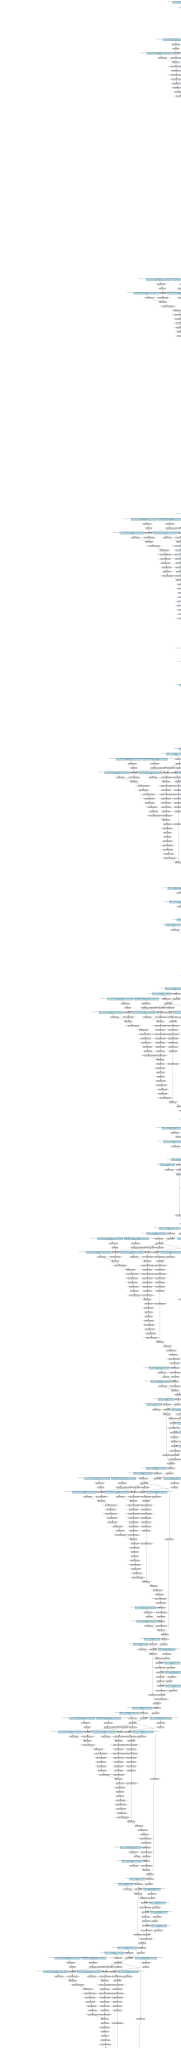

In [149]:
import torchviz
viz = None
def train(model, optimizer, data, lossfn, epochs=1):
    global viz
    model.train()
    i = 0
    for epoch in range(epochs):
        for X, y in tqdm(data):

            optimizer.zero_grad()
            X = X.cuda()
            _lm_output, y_hat = model(X, only_classification=True)
            loss = lossfn(y_hat, y.cuda())
            loss.backward()
            viz = torchviz.make_dot(loss, params=dict(model.named_parameters()))
            optimizer.step()
            i += 1
            if i == 30:
                break
            if i % 100 == 0:
                print(loss)
            #print(tokenizer.batch_decode(X[:2]), y_hat, y)
train(bert, optimizer, data, lossfn)
print(bert.transformer[11].residual.layer_norm.weight.grad)
viz

In [150]:
wts = bert.classification_head.weight
print("req_grad", wts.requires_grad)
if old_wts0 != None:
    print("0 eq", torch.equal(wts, old_wts0))
    print("0 close", torch.allclose(wts, old_wts0))
old_wts0 = wts.clone()
wts = bert.embedding.token_embedding.weight
print("req_grad", wts.requires_grad)
if old_wts1 != None:
    print("1 eq",torch.equal(wts, old_wts1))
    print("1 close", torch.allclose(wts, old_wts1))
old_wts1 = wts.clone()
wts = bert.embedding.layer_norm.weight
print("req_grad", wts.requires_grad)
if old_wts2 != None:
    print("2 eq",torch.equal(wts, old_wts2))
    print("2 close", torch.allclose(wts, old_wts2))
old_wts2 = wts.clone()
wts = bert.transformer[0].attention.project_value.weight
print("req_grad", wts.requires_grad)
if old_wts3 != None:
    print("3 eq",torch.equal(wts, old_wts3))
    print("3 close", torch.allclose(wts, old_wts3))
old_wts3 = wts.clone()

req_grad True
req_grad True
req_grad True
req_grad True


In [151]:
old_wts0 = None
old_wts1 = None
old_wts2 = None
old_wts3 = None


In [152]:
bert.transformer[11].attention.project_out.weight

Parameter containing:
tensor([[-0.0554, -0.0426,  0.0795,  ..., -0.0632,  0.0203,  0.0631],
        [-0.0116,  0.0349,  0.0374,  ..., -0.0617, -0.0558, -0.0371],
        [-0.0203, -0.0466,  0.0308,  ..., -0.0028,  0.0429, -0.0390],
        ...,
        [-0.0479, -0.0008, -0.0056,  ..., -0.0009,  0.0114,  0.0130],
        [ 0.0244, -0.0363,  0.0332,  ...,  0.0308,  0.0056, -0.0025],
        [ 0.0021, -0.0097,  0.0185,  ...,  0.0441,  0.0651, -0.0163]],
       device='cuda:0', requires_grad=True)

In [153]:
params = optimizer.param_groups[0]['params']
type(params)

list

In [154]:
mat = bert.transformer[11].attention.project_out.weight
id(mat)

139870387435616

In [155]:
id(mat) in [id(x) for x in params]

True

In [156]:
print(bert.transformer[11].attention.project_out.weight.grad)

tensor([[-3.4930e-05,  8.2473e-05, -1.1828e-05,  ..., -2.2787e-05,
          4.4776e-06,  6.9363e-05],
        [-1.2619e-04, -2.7652e-04, -6.8758e-05,  ..., -1.1099e-04,
         -6.4518e-05, -1.0915e-04],
        [ 2.3073e-04,  5.1057e-04,  1.3830e-04,  ...,  2.9321e-04,
          1.9194e-04,  1.4937e-04],
        ...,
        [ 2.3520e-04,  7.0239e-04,  2.2005e-04,  ...,  4.9637e-04,
          2.7407e-04,  2.7832e-04],
        [-1.0218e-04, -3.1569e-04, -1.1710e-04,  ..., -2.4080e-04,
         -1.3461e-04, -1.0454e-04],
        [-1.2984e-04, -1.6797e-04, -7.0277e-05,  ..., -1.2975e-04,
         -6.4716e-05, -1.9530e-05]], device='cuda:0')
